## Forecast Benchmarking

This notebook serves to recreate the EPAG RNN forecast for Inlets 1 and 2 at Kubel, before training and evaluating a series of auxiliary ML models designed to be used in the context of a stacked ensemble model.

#### Import

In [23]:
import pandas as pd
import numpy as np
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from solutil import dbqueries as dbq
from solutil import evaluations as ev

#### Parameterization

In [24]:
# TS ID Assignment
act_inlet1 = 11127586
pred_inlet1 = 11055610

act_inlet2 = 11127590
pred_inlet2 = 11055614

act_inlet3 = 11135706
pred_inlet3 = 11135714

In [25]:
# Parameter Assignment
date_from = datetime.strptime('01.03.2021', '%d.%m.%Y')
date_from_trunc = datetime.strptime('01.08.2021', '%d.%m.%Y')
date_to = datetime.now() - timedelta(days=1)

In [26]:
# Load env variables
env_vars = dbq.get_env_variables(mandant='EPAG_ENERGIE')

#### TS Retrieval

In [27]:
# Inlet 1
df_act_inlet1 = dbq.get_timeseries_1h(act_inlet1, date_from, date_to, **env_vars)
df_pred_inlet1 = dbq.get_timeseries_1h(pred_inlet1, date_from, date_to, **env_vars)

In [28]:
# Inlet 2
df_act_inlet2 = dbq.get_timeseries_1h(act_inlet2, date_from, date_to, **env_vars)
df_pred_inlet2 = dbq.get_timeseries_1h(pred_inlet2, date_from, date_to, **env_vars)

In [29]:
# Inlet 3
df_act_inlet3 = dbq.get_timeseries_1h(act_inlet3, date_from_trunc, date_to, **env_vars)
df_pred_inlet3 = dbq.get_timeseries_1h(pred_inlet3, date_from_trunc, date_to, **env_vars)

In [30]:
# Merge datasets
df_act_inlet1.name = 'act_inlet1'
df_inlets = df_act_inlet1.to_frame()
df_inlets['pred_inlet1'] = df_pred_inlet1
df_inlets['act_inlet2'] = df_act_inlet2
df_inlets['pred_inlet2'] = df_pred_inlet2
df_inlets['act_inlet3'] = df_act_inlet3
df_inlets['pred_inlet3'] = df_pred_inlet3

In [31]:
df_inlets

,act_inlet1,pred_inlet1,act_inlet2,pred_inlet2,act_inlet3,pred_inlet3
Timestamp,,,,,,
2021-03-01 00:00:00+01:00,1.563610,1.807735,1.392077,1.216224,NaN,NaN
2021-03-01 01:00:00+01:00,1.572388,1.600004,1.392077,1.151311,NaN,NaN
2021-03-01 02:00:00+01:00,1.569493,1.433065,1.388438,1.091052,NaN,NaN
2021-03-01 03:00:00+01:00,1.560150,1.343673,1.378156,1.040153,NaN,NaN
2021-03-01 04:00:00+01:00,1.544482,1.315153,1.378861,0.997949,NaN,NaN
...,...,...,...,...,...,...
2024-07-11 05:00:00+01:00,2.667879,2.597698,1.724730,1.916142,0.729158,2.158665
2024-07-11 06:00:00+01:00,2.672335,2.655416,1.913998,1.900128,2.569185,2.140117
2024-07-11 07:00:00+01:00,2.685877,2.718658,2.020693,1.904516,2.369047,2.160594


#### Time Series Resampling

In [32]:
n_timestep = 6
df_inlets_4h = df_inlets.copy().resample(timedelta(hours=24 // n_timestep)).mean()

In [33]:
df_inlets_4h

,act_inlet1,pred_inlet1,act_inlet2,pred_inlet2,act_inlet3,pred_inlet3
Timestamp,,,,,,
2021-03-01 00:00:00+01:00,1.566410,1.546119,1.387687,1.124685,NaN,NaN
2021-03-01 04:00:00+01:00,1.511735,1.314004,1.338084,0.949117,NaN,NaN
2021-03-01 08:00:00+01:00,1.407460,1.278593,1.268270,0.889616,NaN,NaN
2021-03-01 12:00:00+01:00,1.890060,1.505975,1.281545,1.019088,NaN,NaN
2021-03-01 16:00:00+01:00,1.951809,1.602436,1.497726,1.107085,NaN,NaN
...,...,...,...,...,...,...
2024-07-10 16:00:00+01:00,2.197160,3.754093,1.835458,2.494740,2.325071,2.315223
2024-07-10 20:00:00+01:00,2.316689,3.721904,1.837262,2.235320,1.876651,2.353096
2024-07-11 00:00:00+01:00,2.615608,2.874484,1.722377,2.044917,2.351094,2.318096


### EPAG Model Evaluation 4h Frequency

In [34]:
df_inlets_trunc = df_inlets_4h[df_inlets_4h.index >= '2023-07-07 00:00:00+01:00'].copy()

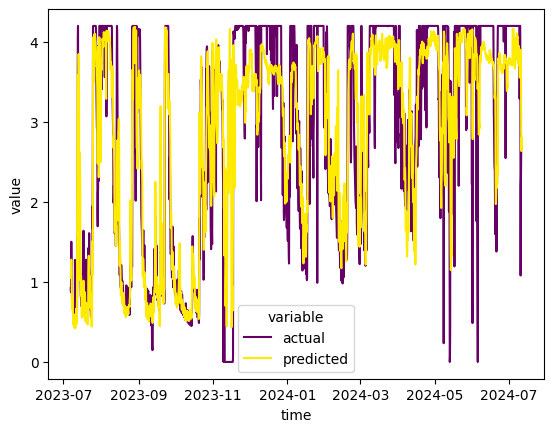

In [35]:
# Actual vs. Prediction Plot
fig = ev.get_act_vs_pred_plot(df_inlets_trunc['act_inlet1'], df_inlets_trunc['pred_inlet1'])

In [36]:
# Get Evaluation Metrics for Inlet 1 
inlet1_metrics = ev.get_eval_metrics(df_inlets_trunc['act_inlet1'], df_inlets_trunc['pred_inlet1'])
inlet1_metrics

{'mae': 0.4797473658725979,
 'mse': 0.504437452958476,
 'rmse': 0.7102376031712739,
 'mape': 188597191601863.75,
 'non-na%': 1.0,
 'n_actual_obs': 2223,
 'n_pred_nas': 0}

In [37]:
# Get Evaluation Metrics for Inlet 2
inlet2_metrics = ev.get_eval_metrics(df_inlets_trunc['act_inlet2'], df_inlets_trunc['pred_inlet2'])
inlet2_metrics

{'mae': 0.459298487638758,
 'mse': 0.4768237667467511,
 'rmse': 0.6905242694842456,
 'mape': 209247334669022.94,
 'non-na%': 1.0,
 'n_actual_obs': 2223,
 'n_pred_nas': 0}

In [38]:
# Get Evaluation Metrics for Inlet 3
df_nonas = df_inlets_trunc
inlet3_metrics = ev.get_eval_metrics(df_inlets_trunc['act_inlet3'], df_inlets_trunc['pred_inlet3'])
inlet3_metrics

{'mae': 0.22578388961831625,
 'mse': 0.12892781293790992,
 'rmse': 0.35906519315844293,
 'mape': 172.9397057313046,
 'non-na%': 1.0,
 'n_actual_obs': 2223,
 'n_pred_nas': 0}

In [39]:
# Save data as csv
#df_inlets_4h.to_csv('stacking_data/ypred_benchmark_4h.csv')

### EPAG Model Evaluation 1h Frequency

In [40]:
df_inlets_trunc = df_inlets[df_inlets.index >= '2023-07-07 00:00:00+01:00'].copy()

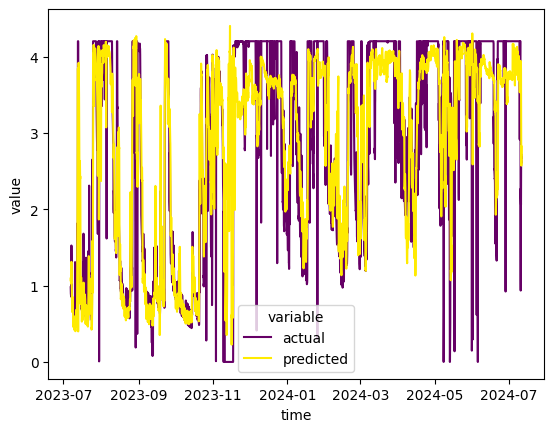

In [41]:
# Actual vs. Prediction Plot
fig = ev.get_act_vs_pred_plot(df_inlets_trunc['act_inlet1'], df_inlets_trunc['pred_inlet1'])

In [42]:
# Get Evaluation Metrics for Inlet 1 
inlet1_metrics = ev.get_eval_metrics(df_inlets_trunc['act_inlet1'], df_inlets_trunc['pred_inlet1'])
inlet1_metrics

{'mae': 0.49512752377729924,
 'mse': 0.5457315630885001,
 'rmse': 0.7387364638952785,
 'mape': 202550323194028.2,
 'non-na%': 1.0,
 'n_actual_obs': 8890,
 'n_pred_nas': 0}

In [43]:
# Get Evaluation Metrics for Inlet 2
inlet2_metrics = ev.get_eval_metrics(df_inlets_trunc['act_inlet2'], df_inlets_trunc['pred_inlet2'])
inlet2_metrics

{'mae': 0.4714897011712889,
 'mse': 0.5110418914631633,
 'rmse': 0.7148719406041639,
 'mape': 258167446102454.75,
 'non-na%': 1.0,
 'n_actual_obs': 8890,
 'n_pred_nas': 0}

In [44]:
# Save data as csv
#df_inlets.to_csv('stacking_data/ypred_benchmark_1h.csv')